## Method 3: combine doc2vec with standard logistic regression classifier

1. Train vector representations of documents with gensim.models.Doc2Vec

2. Feed the document vectors to the standard logistic regression classifier

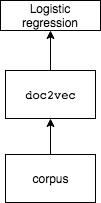

In [13]:
from IPython.display import Image
Image("doc2vec.png")

In [12]:
import locale
import glob
import os.path
import requests
import tarfile
import sys
import codecs
import smart_open
import time
from collections import namedtuple
import gensim
from gensim.models import Doc2Vec
import multiprocessing
from random import shuffle
import theano.tensor as tensor
from theano import config
import numpy
import theano
import timeit

In [2]:
# Convert text to lower-case and strip punctuation/symbols from words
def normalize_text(text):
    norm_text = text.lower()
    # Replace breaks with spaces
    norm_text = norm_text.replace('<br />', ' ')

    # Pad punctuation with spaces on both sides
    for char in [':', '"', ',', ')', '!', '?', ';']:
        norm_text = norm_text.replace(char, ' ' + char)

    norm_text = norm_text.replace('(', '(' + ' ')
    norm_text = norm_text.replace('.', ' ' + '.')
    return norm_text

In [3]:
def clean_files(dirname):
    if sys.version > '3':
        control_chars = [chr(0x85)]
    else:
        control_chars = [unichr(0x85)]

    folders = ['train/pos', 'train/neg', 'test/pos', 'test/neg']
    alldata = u''

    for fol in folders:
        temp = u''
        output = fol.replace('/', '-') + '.txt'

        txt_files = glob.glob(os.path.join(dirname, fol, '*.txt')) # get all text files
        for txt in txt_files:
            with smart_open.smart_open(txt, "rb") as t:
                t_clean = t.read().decode("utf-8")
                for c in control_chars:
                    t_clean = t_clean.replace(c, ' ')
                temp += t_clean
            temp += "\n"
        temp_norm = normalize_text(temp)

        with smart_open.smart_open(os.path.join(dirname, output), "wb") as n:
            n.write(temp_norm.encode("utf-8"))
        alldata += temp_norm

    with smart_open.smart_open(os.path.join(dirname, 'alldata-id.txt'), 'wb') as f:
        for idx, line in enumerate(alldata.splitlines()):
            num_line = u"_*{0} {1}\n".format(idx, line)
            f.write(num_line.encode("utf-8"))

In [4]:
def get_sentences(alldata_filename):
    SentimentDocument = namedtuple('SentimentDocument', 'words tags split sentiment')
    alldocs = []  # Will hold all docs in original order

    with open(alldata_filename, encoding='utf-8') as alldata:
        for line_no, line in enumerate(alldata):
            tokens = gensim.utils.to_unicode(line).split()
            words = tokens[1:]
            tags = [line_no]
            split = ['train', 'test'][line_no//25000]  # 25k train, 25k test
            sentiment = [1.0, 0.0, 1.0, 0.0][line_no//12500] #[12.5K pos, 12.5K neg]*2
            alldocs.append(SentimentDocument(words, tags, split, sentiment))

    train_docs = [doc for doc in alldocs if doc.split == 'train']
    test_docs = [doc for doc in alldocs if doc.split == 'test']
    doc_list = alldocs[:]  # For reshuffling per pass
    return (train_docs, test_docs, doc_list)

In [5]:
def train_doc2vec(all_docs, num_epoch=10, size=128):
    cores = multiprocessing.cpu_count()
    assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"

    model = Doc2Vec(dm=1, dm_concat=1, size=size,
                window=5, negative=5, hs=0, min_count=1, workers=cores, sample=1e-4)
    model.build_vocab(all_docs)

    alpha, min_alpha = (0.025, 0.001)
    alpha_delta = (alpha - min_alpha) / num_epoch

    for epoch in range(num_epoch):
        shuffle(all_docs)
        model.alpha, model.min_alpha = alpha, min_alpha
        model.train(all_docs, total_examples=len(all_docs), epochs=1)
        alpha -= alpha_delta

    return model

In [6]:
# neural network classifier
class NN_classifier(object):
    def __init__(self, rng, input, n_in, n_out, U=None, b=None):
        self.input = input

        if U is None:
            U_values = 0.01 * rng.randn(n_in, n_out).astype(config.floatX)
            U = theano.shared(value=U_values, name='U', borrow=True)

        if b is None:
            b_values = numpy.zeros((n_out,)).astype(config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.U = U
        self.b = b

        self.pred = tensor.nnet.softmax(tensor.dot(input, self.U) + self.b)

        self.y_pred = self.pred.argmax(axis=1)

        self.weight_decay = (self.U ** 2).sum()

        self.params = [self.U, self.b]

    def cost(self, y):
        off = 1e-8
        if self.pred.dtype == 'float16':
            off = 1e-6
        return -tensor.log(self.pred[tensor.arange(y.shape[0]), y] + off).mean()

    def errors(self, y):
        if y.ndim != self.y_pred.ndim:
            raise TypeError(
                'y should have the same shape as self.y_pred',
                ('y', y.type, 'y_pred', self.y_pred.type)
            )
        if y.dtype.startswith('int'):
            return tensor.mean(tensor.neq(self.y_pred, y))
        else:
            raise NotImplementedError()

In [7]:
def load_dataset(model, train_set, test_set, valid_portion=0.1, test_size=0):
    train_set_y, train_set_x = zip(*[(doc.sentiment, model.docvecs[doc.tags[0]])
                                            for doc in train_set])

    n_samples = len(train_set_x)
    sidx = numpy.random.permutation(n_samples)
    n_train = int(numpy.round(n_samples * (1. - valid_portion)))

    valid_x = [train_set_x[s] for s in sidx[n_train:]]
    valid_y = [train_set_y[s] for s in sidx[n_train:]]

    train_x = [train_set_x[s] for s in sidx[:n_train]]
    train_y = [train_set_y[s] for s in sidx[:n_train]]

    test_set_y, test_set_x = zip(*[(doc.sentiment, model.docvecs[doc.tags[0]])
                                            for doc in test_set])
    
    if test_size > 0:
        idx = numpy.arange(len(test_set_x))
        numpy.random.shuffle(idx)
        idx = idx[:test_size]
        test = ([test_set_x[n] for n in idx], [test_set_y[n] for n in idx])

    def shared_dataset(data_x, data_y, borrow=True):
        shared_x = theano.shared(numpy.asarray(data_x,
                                               dtype=theano.config.floatX),
                                 borrow=borrow)
        shared_y = theano.shared(numpy.asarray(data_y,
                                               dtype=theano.config.floatX),
                                 borrow=borrow)
        return shared_x, tensor.cast(shared_y, 'int32')

    test_set_x, test_set_y = shared_dataset(test[0], test[1])
    valid_set_x, valid_set_y = shared_dataset(valid_x, valid_y)
    train_set_x, train_set_y = shared_dataset(train_x, train_y)

    rval = [(train_set_x, train_set_y), (valid_set_x, valid_set_y),
            (test_set_x, test_set_y)]

    return rval

In [8]:
def NN_classifier_optimize(doc2vec_model, train_set, test_set,
                           test_size=5000, batch_size=16, 
                           decay_c=0.001, learning_rate=0.001,
                           valid_portion=0.1, max_epoch=100,
                           patience=50, validFreq=-1):

    train, valid, test = load_dataset(doc2vec_model, train_set, test_set,
                                      test_size=test_size, valid_portion=valid_portion)

    train_x, train_y = train
    valid_x, valid_y = valid
    test_x, test_y = test
    print(train_x.shape.eval())

    n_train_batches = train_x.get_value(borrow=True).shape[0] // batch_size
    n_valid_batches = valid_x.get_value(borrow=True).shape[0] // batch_size
    n_test_batches = test_x.get_value(borrow=True).shape[0] // batch_size

    index = tensor.iscalar()
    x = tensor.matrix('x')
    y = tensor.ivector('y')

    rng = numpy.random.RandomState(1234)
    n_in = train_x.get_value(borrow=True).shape[1]
    classifier = NN_classifier(rng= rng, input=x, n_in=n_in, n_out=2)

    test_model = theano.function(
        inputs = [index],
        outputs = classifier.errors(y),
        givens = {
            x: test_x[index * batch_size:(index + 1) * batch_size],
            y: test_y[index * batch_size:(index + 1) * batch_size]
        }
    )

    validate_model = theano.function(
        inputs = [index],
        outputs = classifier.errors(y),
        givens = {
            x: valid_x[index * batch_size:(index + 1) * batch_size],
            y: valid_y[index * batch_size:(index + 1) * batch_size]
        }
    )

    cost = classifier.cost(y)
    if decay_c > 0.:
        decay_c = theano.shared(numpy.asarray(decay_c, dtype=config.floatX), name='decay_c')
        classifier.weight_decay *= decay_c
        cost += classifier.weight_decay

    g_U = tensor.grad(cost=cost, wrt=classifier.U)
    g_b = tensor.grad(cost=cost, wrt=classifier.b)

    updates = [(classifier.U, classifier.U - learning_rate * g_U),
               (classifier.b, classifier.b - learning_rate * g_b)]

    train_model = theano.function(
        inputs = [index],
        outputs = cost,
        updates = updates,
        givens = {
            x: train_x[index * batch_size: (index + 1) * batch_size],
            y: train_y[index * batch_size: (index + 1) * batch_size]
        }
    )

    print('... training the model')
    patience_increase = 2
    improvement_threshold = 0.995

    if validFreq == -1:
        validFreq = n_train_batches

    best_validation_loss = numpy.inf
    test_score = 0.

    start_time = timeit.default_timer()

    done_looping = False
    epoch = 0
    while (epoch < max_epoch) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):
            iter = (epoch - 1) * n_train_batches + minibatch_index
            if (iter + 1) % validFreq == 0:
                validation_losses = [validate_model(i)
                                     for i in range(n_valid_batches)]
                this_validation_loss = numpy.mean(validation_losses)
                print('epoch %i, minibatch %i/%i,validation error %f %%' %(epoch,
                                                                           minibatch_index + 1,
                                                                           n_train_batches,
                                                                          this_validation_loss * 100.))
                if this_validation_loss < best_validation_loss:
                    if this_validation_loss < best_validation_loss * improvement_threshold:
                        patience = max(patience, iter * patience_increase)
                    best_validation_loss = this_validation_loss

                    test_losses = [test_model(i) for i in range(n_test_batches)]
                    test_score = numpy.mean(test_losses)
                    print(('     epoch %i, minibatch %i/%i, test error of'
                                ' best model %f %%') %(epoch,
                                                       minibatch_index + 1,
                                                       n_train_batches,
                                                       test_score * 100.))
                if patience <= iter:
                    done_looping = True
                    break
    end_time = timeit.default_timer()
    print(('Optimization complete with best validation score of %f %%,'
           'with test performance %f %%')%(best_validation_loss * 100.,
                                           test_score * 100.))
    print('The code run for %d epochs, with %f epochs/sec' % (
            epoch, 1. * epoch / (end_time - start_time)))

In [9]:
def main(reload=None, emb_size=128, doc2vec_epoch=20):
    dirname = '/Users/lifa08/Local_documents/Machine_Learning/Miniproject_test/aclImdb'
    alldata_file = os.path.join(dirname, 'alldata-id.txt')

    if not os.path.isfile(alldata_file):
        clean_files(dirname)

    assert os.path.isfile(alldata_file), "alldata-id.txt unavailable"

    train_set, test_set, all_docs = get_sentences(alldata_file)

    if reload is not None:
        model = Doc2Vec.load('./imdb.d2v')
    else:
        # train doc2vec
        print('training doc2vec')
        start_time = timeit.default_timer()
        model = train_doc2vec(all_docs, num_epoch=doc2vec_epoch, size=emb_size)
        model.save('./imdb.d2v')
        end_time = timeit.default_timer()
        print('doc2vec training took %f sec' %(end_time - start_time))

    NN_classifier_optimize(doc2vec_model=model, train_set=train_set, test_set=test_set)

In [10]:
main()

training doc2vec
doc2vec training took 516.507186 sec
[22500   128]
... training the model
epoch 1, minibatch 1406/1406,validation error 47.195513 %
     epoch 1, minibatch 1406/1406, test error of best model 46.794872 %
epoch 2, minibatch 1406/1406,validation error 47.195513 %
Optimization complete with best validation score of 47.195513 %,with test performance 46.794872 %
The code run for 2 epochs, with 44.244200 epochs/sec


In [11]:
if __name__ == '__main__':
    main()

training doc2vec
doc2vec training took 562.559510 sec
[22500   128]
... training the model
epoch 1, minibatch 1406/1406,validation error 48.237179 %
     epoch 1, minibatch 1406/1406, test error of best model 49.018429 %
epoch 2, minibatch 1406/1406,validation error 48.237179 %
Optimization complete with best validation score of 48.237179 %,with test performance 49.018429 %
The code run for 2 epochs, with 51.006320 epochs/sec
